### Vehicle Collision Analysis

Analyst: Daniel Elkin <br />
Date: 06/12/2019

In [141]:
import numpy as np
import matplotlib as plt
import pandas as pd
from scipy.stats import ttest_ind

In [2]:
%matplotlib inline

### Contents:
* [Data Loading and Validation](#load)
* [Collision Times](#times)
* [Vehicle Types](#types)
* [Report](#report)

#### I. Data Loading and Validation <a id="load"/>

First we'll load the data.

In [3]:
# data_file = "data/small.csv"
data_file = "data/NYPD_Motor_Vehicle_Collisions.csv"

rows = !wc -l < $data_file
rows = int(rows[0])

print(f"There are {rows} rows in the data file.")

There are 1509271 rows in the data file.


In [4]:
# the columns of interest for the questions in the prompt
cols = [
    "DATE",
    "TIME",
    "BOROUGH",                                          
    "NUMBER OF PERSONS INJURED",        
    "NUMBER OF PERSONS KILLED",       
    "NUMBER OF PEDESTRIANS INJURED",    
    "NUMBER OF PEDESTRIANS KILLED",     
    "NUMBER OF CYCLIST INJURED",        
    "NUMBER OF CYCLIST KILLED",         
    "NUMBER OF MOTORIST INJURED",       
    "NUMBER OF MOTORIST KILLED",        
    "UNIQUE KEY",                       
    "VEHICLE TYPE CODE 1",              
    "VEHICLE TYPE CODE 2",              
    "VEHICLE TYPE CODE 3",              
    "VEHICLE TYPE CODE 4",              
    "VEHICLE TYPE CODE 5"
]   

df = pd.read_csv(data_file, 
                 parse_dates=[["DATE", "TIME"]],
                 usecols=cols
                )

In [5]:
# confirm we've loaded all rows
len(df)

1509269

Next, we'll rename the columns for readability and use only the data from 2018.

In [6]:
df.rename(columns=lambda c: c.lower().replace(" ", "_"), inplace=True)
df = df[df.date_time.dt.year == 2018]

Let's examine the remaining data for potential issues.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 269 to 320494
Data columns (total 16 columns):
date_time                        231485 non-null datetime64[ns]
borough                          149173 non-null object
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
unique_key                       231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null o

In [8]:
# ensure that the unique key is really unique
assert len(df.unique_key) == len(df.unique_key.unique())

In [9]:
# see how many null values we have
df.isnull().sum()

date_time                             0
borough                           82312
number_of_persons_injured             5
number_of_persons_killed             14
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
unique_key                            0
vehicle_type_code_1                1397
vehicle_type_code_2               49022
vehicle_type_code_3              217632
vehicle_type_code_4              228613
vehicle_type_code_5              230723
dtype: int64

We have 231,485 collisions in the dataset. We've confirmed that the data is complete for the `date_time` and `unique_key` columns. We'll further examine and clean the data below.

#### II. Collision times <a id="times"/>

We'll create a new dataframe with only the columns needed to answer the question of when collisions occur.

In [435]:
# subset the fields needed
df1 = df[["date_time", "unique_key", "borough"]].copy()

# add a derived column for day of week
df1["day_of_week"] = df1.date_time.dt.weekday_name

# make the time of the collision the index
df1.set_index("date_time", inplace=True)

df1.head()

,unique_key,borough,day_of_week
date_time,,,
2018-12-29 19:45:00,4055860,NaN,Saturday
2018-12-24 10:00:00,4055249,NaN,Monday
2018-12-17 14:30:00,4047978,NaN,Monday
2018-12-31 00:00:00,4055273,BRONX,Monday
2018-12-31 00:00:00,4055449,BROOKLYN,Monday


We'll bin the collisions by the hour at which they occur and plot them.

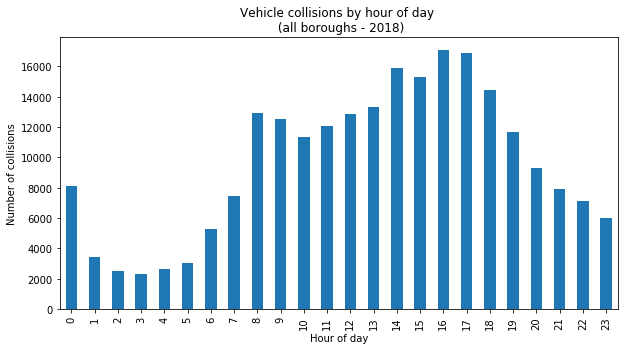

In [437]:
group = df1.groupby(df1.index.hour).count().unique_key
ax = group.plot(kind="bar", 
                figsize=(10, 5),
                title="Vehicle collisions by hour of day \n (all boroughs - 2018)")

ax.set_xlabel("Hour of day")
_ = ax.set_ylabel("Number of collisions")

We do not have complete data for the boroughs in which collisions occur, but we can visualize the data we do have by borough as well.

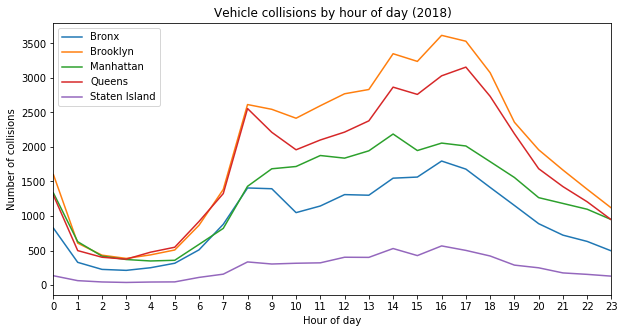

In [438]:
group = (df1.groupby([df1.index.hour, "borough"])
         .unique_key
         .count()
         .unstack())

ax = group.plot(figsize=(10, 5), 
                xticks=range(0, 24), 
                title="Vehicle collisions by hour of day (2018)")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of collisions")

# rename the legends so values are not all uppercase 
boroughs = [str(b).title() 
            for b in df1.borough.dropna().unique()]
_ = ax.legend(boroughs)

We will discuss further in the conclusion, but the graphs reveal that most accidents occur during the day, particularly between the hours of 4:00 and 6:00pm.

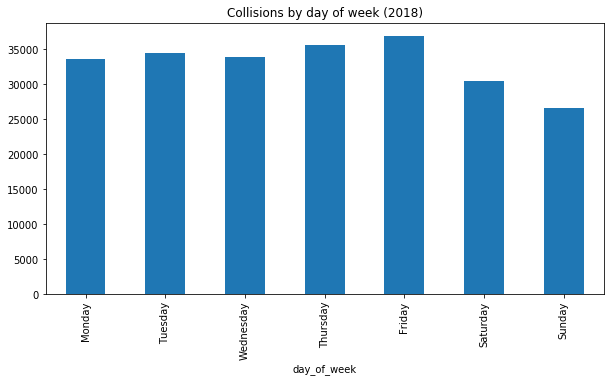

In [453]:
# order the grouped dataframe by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group = (df1.groupby(["day_of_week"])
         .count()
         .unique_key
         .reindex(days))

group.plot(figsize=(10, 5), 
           kind="bar", 
           title="Collisions by day of week (2018)")

ax.set_xlabel("Day of week")
_ = ax.set_ylabel("Number of collisions")

#### III. Vehicle type <a id="types" />

#### a. Data preparation

We'll create a dataframe containing the relevant fields for answering the second question regarding the effect of vehicle type on injury and mortality rates.

In [76]:
df2 = df.drop(["date_time", "borough"], axis=1).copy()
df2 = df2.set_index("unique_key")
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 4055860 to 3820878
Data columns (total 13 columns):
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 24.7+ MB


We note that there are 5 vehicle type fields for each collision and that the number of not-null values in columns 1 and 2 are an order of magnitude greater than the number of not-null values in columns 3, 4 and 5. In the following analysis, we'll examine just `vehicle_type_code_1` and `vehicle_type_code_2` in order to have a more manageble number of vehicle-type combinations to examine.

We create a new column called `vehicle_type` that contains just `vehicle_type_code_1` in the case that `vehicle_type_code_2` is null, and otherwise contains a sorted concatenation of the two fields.

In [77]:
# drop the approximately 1300 instances where there are no vehicle types
df2.dropna(subset=["vehicle_type_code_1"], inplace=True)

# combine the first two vehicle type columns with a "+" as the delimiter
df2["vehicle_type"] = (np.where(df2.vehicle_type_code_1 < df2.vehicle_type_code_2, 
                                   df2.vehicle_type_code_1.str.lower() + "+" + df2.vehicle_type_code_2.str.lower(), 
                                   df2.vehicle_type_code_2.str.lower() + "+" + df2.vehicle_type_code_1.str.lower()))

# if the column is null, then the second vehicle type is null, so use the first type
df2["vehicle_type"] = (np.where(df2.vehicle_type_code_2.isna(), 
                                  df2.vehicle_type_code_1.str.lower() + " only",
                                  df2.vehicle_type))

In [108]:
df2[["vehicle_type_code_1", "vehicle_type_code_2", "vehicle_type"]].head(10)

,vehicle_type_code_1,vehicle_type_code_2,vehicle_type
unique_key,,,
4055860,Sedan,NaN,sedan only
4055249,Sedan,NaN,sedan only
4055273,Sedan,Station Wagon/Sport Utility Vehicle,sedan+station wagon/sport utility vehicle
4055449,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,station wagon/sport utility vehicle+station wa...
4055005,Van,Sedan,sedan+van
4055499,Station Wagon/Sport Utility Vehicle,NaN,station wagon/sport utility vehicle only
4055512,Station Wagon/Sport Utility Vehicle,Sedan,sedan+station wagon/sport utility vehicle
4060683,Station Wagon/Sport Utility Vehicle,Sedan,sedan+station wagon/sport utility vehicle
4062834,Pick-up Truck,NaN,pick-up truck only


#### b. Mortality

We'll first examine the total number of fatalities by vehicle type.

vehicle_type
station wagon/sport utility vehicle only          44.0
sedan only                                        22.0
passenger vehicle only                            14.0
sport utility / station wagon only                13.0
motorcycle+station wagon/sport utility vehicle    13.0
Name: number_of_persons_killed, dtype: float64
Total number of fatalities: 223


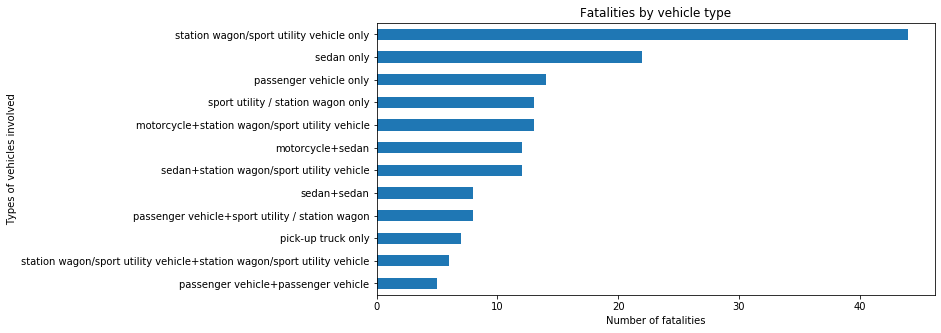

In [126]:
grouped = (df2[df2["number_of_persons_killed"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_killed
 .sum()
 .sort_values(ascending=False)
)
total_fatalities = int(grouped.sum())

title = "Fatalities by vehicle type"
ax = (grouped[grouped >= 5]
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of fatalities")
ax.set_ylabel("Types of vehicles involved")
print(grouped.head())
print(f"Total number of fatalities: {total_fatalities}")

We see that there were 223 total fatalities and that the top vehicle type was a single vehicle (SUV/station wagon, sedan or passenger vehicle). A cursory inspection of the data reveals that in many cases these were instances where a pedestrian was killed.

We also see a that a large number of fatalities included a motorcycle. Let's further examine this.

In [140]:
motorcycles = df2[df2.vehicle_type.str.contains("motorcycle")]
others = df2[~df2.vehicle_type.str.contains("motorcycle")]

percent_motorcycle = len(motorcycles) / len(df2) * 100
percent_motorcycle_fatal = int(motorcycles.number_of_persons_killed.sum() / total_fatalities * 100)

motorcycle_mean_fatalities = motorcycles.number_of_persons_killed.mean()
others_mean_fatalities = others.number_of_persons_killed.mean()
print(f"Percent of collisions involving a motorcycle: {percent_motorcycle:.2}%")
print(f"Percent of fatalities involving a motorcycle: {percent_motorcycle_fatal}%")
print()
print(f"Mean fatalities for collisions involving a motorcycle: {motorcycle_mean_fatalities:.2}")
print(f"Mean fatalities for collisions not involving a motorcycle: {others_mean_fatalities:.2}")

Percent of collisions involving a motorcycle: 0.88%
Percent of fatalities involving a motorcycle: 14%

Mean fatalities for collisions involving a motorcycle: 0.016
Mean fatalities for collisions not involving a motorcycle: 0.00083


It appears that collisions involving a motorcycle are much more likely to result in a fatality. Let's conduct a t-test to confirm that this is a signifincat result. 

In [143]:
target = "number_of_persons_killed"
ttest_ind(motorcycles.dropna(subset=[target]).number_of_persons_killed, 
          others.dropna(subset=[target]).number_of_persons_killed)

Ttest_indResult(statistic=22.0470164544321, pvalue=1.319883655291921e-107)

We find that collisions involving motorcycles are more likely to include a fatality than collisions involving other vehicle types.

#### c. Injury

Total number of injuries: 60889

vehicle_type
sedan+station wagon/sport utility vehicle                                  9693.0
sedan+sedan                                                                7839.0
station wagon/sport utility vehicle+station wagon/sport utility vehicle    4469.0
passenger vehicle+sport utility / station wagon                            4275.0
sedan only                                                                 4223.0
passenger vehicle+passenger vehicle                                        3554.0
station wagon/sport utility vehicle only                                   3276.0
passenger vehicle only                                                     2165.0
sport utility / station wagon+sport utility / station wagon                2067.0
sport utility / station wagon only                                         1698.0
bike+sedan                                                                 1452.0
bike+station wagon/sport utility vehicle            

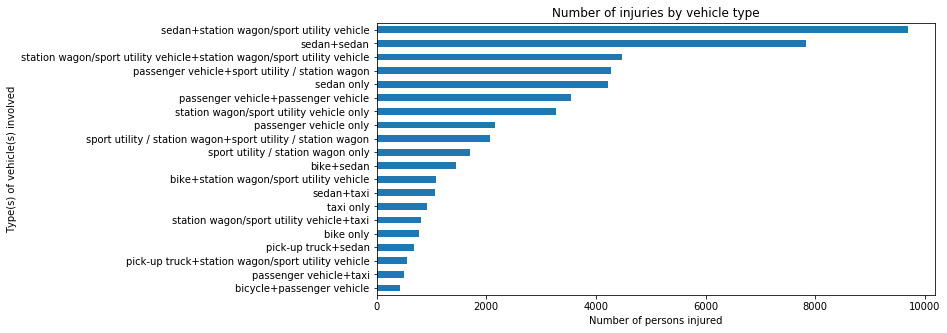

In [159]:
grouped = (df2[df2["number_of_persons_injured"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_injured
 .sum()
 .sort_values(ascending=False)
)
total_injuries = int(grouped.sum())
print(f"Total number of injuries: {total_injuries}\n")

title = "Number of injuries by vehicle type"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
ax.set_ylabel("Type(s) of vehicle(s) involved")
print(grouped.head(20))

Total number of injuries: 60889

vehicle_type
sedan+station wagon/sport utility vehicle                                  9693.0
sedan+sedan                                                                7839.0
station wagon/sport utility vehicle+station wagon/sport utility vehicle    4469.0
passenger vehicle+sport utility / station wagon                            4275.0
sedan only                                                                 4223.0
passenger vehicle+passenger vehicle                                        3554.0
station wagon/sport utility vehicle only                                   3276.0
passenger vehicle only                                                     2165.0
sport utility / station wagon+sport utility / station wagon                2067.0
sport utility / station wagon only                                         1698.0
bike+sedan                                                                 1452.0
bike+station wagon/sport utility vehicle            

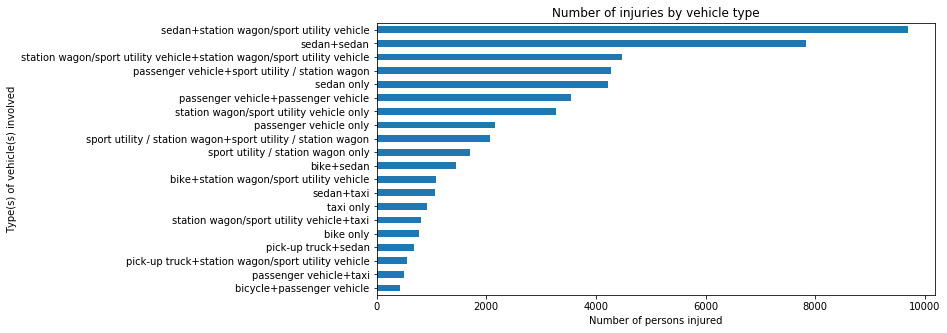

In [177]:

grouped = (df2[df2["number_of_persons_injured"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_injured
 .sum()
 .sort_values(ascending=False)
)
grouped.head(100)
total_injuries = int(grouped.sum())
print(f"Total number of injuries: {total_injuries}\n")

title = "Number of injuries by vehicle type"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
ax.set_ylabel("Type(s) of vehicle(s) involved")
print(grouped.head(20))

In [208]:
inj = (df2.groupby("vehicle_type")
       .vehicle_type
       .count())
inj = inj[inj > .001 * len(df2)]
inj.head()

vehicle_type
bicycle+passenger vehicle                    532
bicycle+sport utility / station wagon        379
bike only                                    836
bike+sedan                                  1810
bike+station wagon/sport utility vehicle    1346
Name: vehicle_type, dtype: int64

vehicle_type
ds+sport utility / station wagon                                           1.916667
bus+station wagon/sport utility vehicle                                    1.882716
bu+sport utility / station wagon                                           1.761905
bus+sedan                                                                  1.734884
bus+taxi                                                                   1.708333
station wagon/sport utility vehicle+taxi                                   1.700422
sedan+taxi                                                                 1.643411
station wagon/sport utility vehicle+van                                    1.603774
sedan+sedan                                                                1.601430
station wagon/sport utility vehicle+station wagon/sport utility vehicle    1.597783
sedan+station wagon/sport utility vehicle                                  1.584341
passenger vehicle+passenger vehicle                            

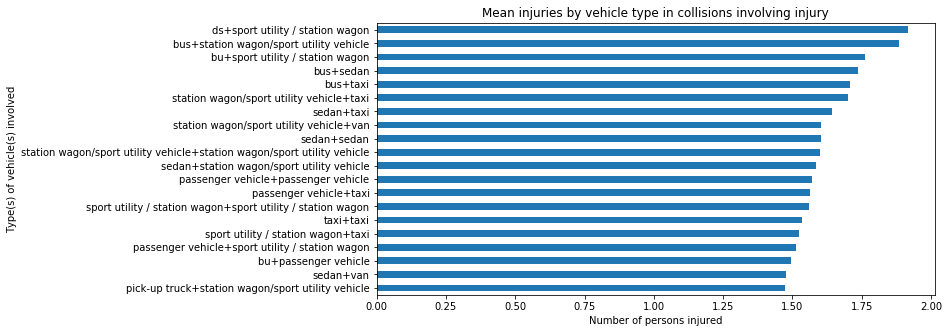

In [218]:
dfi = df2[df2.vehicle_type.isin(inj.index)]
grouped = (dfi[dfi["number_of_persons_injured"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_injured
 .mean()
 .sort_values(ascending=False)
)
grouped.head(20)

title = "Mean injuries by vehicle type in collisions involving injury"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
ax.set_ylabel("Type(s) of vehicle(s) involved")
print(grouped.head(20))

In [216]:
taxi = df2[df2.vehicle_type.str.contains("taxi")]
non_taxi = df2[~df2.vehicle_type.str.contains("taxi")]

In [220]:
print(taxi.number_of_persons_injured.mean())
non_taxi.number_of_persons_injured.mean()

0.2610290209418518


0.26496078459215505

In [223]:
target = "number_of_persons_injured"
ttest_ind(taxi.dropna(subset=[target]).number_of_persons_injured, 
          non_taxi.dropna(subset=[target]).number_of_persons_injured)

Ttest_indResult(statistic=-0.7887631115893325, pvalue=0.43025128607465657)

In [215]:
df2[(df2.vehicle_type=="bus+sport utility / station wagon") & (df2["number_of_persons_injured"] >= 1)]

,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,vehicle_type
unique_key,,,,,,,,,,,,,,


In [173]:
len(df2[df2["number_of_persons_injured"].isna()])
.001 * len(df2)

230.088

In [19]:
# create injury dataframe
cols = [c for c in df2.columns if not c.endswith("killed")]
dfi = df2[cols]

# create fatal dataframe
cols = [c for c in df2.columns if not c.endswith("injured")]
dff = df2[cols]

In [125]:
# TODO: deal with NA and invalid sums
dff = dff[(dff["number_of_persons_killed"] != 0) & (pd.notnull(dff["number_of_persons_killed"]))]
len(dff["number_of_persons_killed"])
dff

,number_of_persons_killed,number_of_pedestrians_killed,number_of_cyclist_killed,number_of_motorist_killed,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,vehicle_type
unique_key,,,,,,,,,,
4055911,1.0,1,0,0,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,station wagon/sport utility vehicle only
4060509,1.0,1,0,0,Sedan,NaN,NaN,NaN,NaN,sedan only
4060507,1.0,1,0,0,Sedan,NaN,NaN,NaN,NaN,sedan only
4056090,1.0,0,0,1,Sedan,Sedan,Station Wagon/Sport Utility Vehicle,Pick-up Truck,Sedan,sedan+sedan
4056110,1.0,0,0,1,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,sedan+station wagon/sport utility vehicle
4049397,1.0,1,0,0,Bus,NaN,NaN,NaN,NaN,bus only
4048562,1.0,1,0,0,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,station wagon/sport utility vehicle only
4047766,1.0,1,0,0,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,station wagon/sport utility vehicle only
4055926,1.0,1,0,0,Sedan,NaN,NaN,NaN,NaN,sedan only


In [48]:
dff[dff["number_of_persons_killed"] != dff["number_of_pedestrians_killed"] + \
         dff["number_of_cyclist_killed"] + dff["number_of_motorist_killed"]]

,number_of_persons_killed,number_of_pedestrians_killed,number_of_cyclist_killed,number_of_motorist_killed,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
unique_key,,,,,,,,,
4025853,1.0,0,0,0,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [35]:
def assign_vehicle_type(df):
    df["vehicle_type"] = (np.where(df.vehicle_type_code_1 < df.vehicle_type_code_2, 
                                   df.vehicle_type_code_1 + ":" + df.vehicle_type_code_2, 
                                   df.vehicle_type_code_2 + ":" + df.vehicle_type_code_1))
    
    df["vehicle_type"] = (np.where(df.vehicle_type_code_2.isna(), 
                                  df.vehicle_type_code_1,
                                  df.vehicle_type))
    return df

In [36]:
d = assign_vehicle_type(dff)
d.vehicle_type.value_counts()

Station Wagon/Sport Utility Vehicle                                        48
Sedan                                                                      24
PASSENGER VEHICLE                                                          14
SPORT UTILITY / STATION WAGON                                              13
Motorcycle:Station Wagon/Sport Utility Vehicle                             12
Motorcycle:Sedan                                                           12
Sedan:Station Wagon/Sport Utility Vehicle                                  11
Sedan:Sedan                                                                 8
PASSENGER VEHICLE:SPORT UTILITY / STATION WAGON                             8
Station Wagon/Sport Utility Vehicle:Station Wagon/Sport Utility Vehicle     6
Pick-up Truck                                                               5
Taxi                                                                        5
Bus                                                             

In [537]:
fatalities.vehicle_type_code_1.value_counts()

Station Wagon/Sport Utility Vehicle    70
Sedan                                  49
PASSENGER VEHICLE                      23
SPORT UTILITY / STATION WAGON          20
Motorcycle                             18
Pick-up Truck                           8
Taxi                                    8
Bus                                     5
PICK-UP TRUCK                           4
Garbage or Refuse                       3
TAXI                                    2
TK                                      2
Bike                                    2
Box Truck                               2
GG                                      1
FB                                      1
TN                                      1
Moped                                   1
MOTORCYCLE                              1
Tractor Truck Gasoline                  1
Van                                     1
Utili                                   1
Convertible                             1
BU                                

In [538]:
fatalities.vehicle_type_code_2.value_counts()

Station Wagon/Sport Utility Vehicle    28
Sedan                                  18
Motorcycle                             13
PASSENGER VEHICLE                       9
SPORT UTILITY / STATION WAGON           8
Bike                                    4
Box Truck                               3
BICYCLE                                 3
Taxi                                    2
Open Body                               2
Motorbike                               1
Beverage Truck                          1
Pick-up Truck                           1
Tractor Truck Diesel                    1
VN                                      1
Flat Bed                                1
RF                                      1
Bus                                     1
Motorscooter                            1
Name: vehicle_type_code_2, dtype: int64

In [541]:
fatalities.vehicle_type_code_5.value_counts()

Sedan                                  3
SPORT UTILITY / STATION WAGON          3
PASSENGER VEHICLE                      1
Pick-up Truck                          1
Station Wagon/Sport Utility Vehicle    1
Name: vehicle_type_code_5, dtype: int64

Let's see how many people were killed as a result of a collision in 2018.

In [518]:
injury["number_of_persons_injured"].sum()

61922.0

In [497]:
ugh = df2[df2["number_of_persons_killed"] != df2["number_of_pedestrians_killed"] + \
         df2["number_of_cyclist_killed"] + df2["number_of_motorist_killed"]]

In [498]:
ugh

,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
unique_key,,,,,,,,,,,,,
4056211,0.0,NaN,0,0,0,0,0,0,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4051650,1.0,NaN,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4026317,0.0,0.0,0,0,0,0,0,1,Sedan,NaN,NaN,NaN,NaN
4028365,1.0,NaN,0,0,0,0,0,0,Taxi,NaN,NaN,NaN,NaN
4026515,0.0,NaN,0,0,0,0,0,0,Bus,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4026451,2.0,NaN,0,0,0,0,0,0,Pick-up Truck,NaN,NaN,NaN,NaN
4026434,0.0,NaN,0,0,0,0,0,0,Taxi,NaN,NaN,NaN,NaN
4026403,NaN,NaN,0,0,0,0,1,0,Taxi,NaN,NaN,NaN,NaN
4026267,0.0,NaN,0,0,0,0,0,0,Sedan,NaN,NaN,NaN,NaN


In [534]:
fatal.vehicle_type_code_1.value_counts()

Sedan                                  71563
Station Wagon/Sport Utility Vehicle    55294
PASSENGER VEHICLE                      35478
SPORT UTILITY / STATION WAGON          27455
Taxi                                    7382
Pick-up Truck                           4801
TAXI                                    4305
Box Truck                               3270
Bus                                     2350
PICK-UP TRUCK                           2298
Bike                                    2059
TK                                      1452
Tractor Truck Diesel                    1332
BU                                      1306
Van                                     1076
Motorcycle                               957
DS                                       544
Convertible                              516
Dump                                     470
VN                                       433
PK                                       356
Ambulance                                325
Flat Bed  

In [293]:
df.vehicle_type_code_2.value_counts()

Sedan                                  336
Station Wagon/Sport Utility Vehicle    287
Bike                                    33
Taxi                                    33
Pick-up Truck                           30
Box Truck                               27
Bus                                     22
Flat Bed                                 7
Tractor Truck Diesel                     7
Dump                                     4
Carry All                                3
Ambulance                                3
Tractor Truck Gasoline                   2
Motorcycle                               2
Concrete Mixer                           2
Van                                      2
Tow Truck / Wrecker                      2
PK                                       2
WHITE                                    1
Moped                                    1
Vanette                                  1
Convertible                              1
Tanker                                   1
BACK       

In [489]:
# assert len(df[df["number_of_persons_killed"] != df["number_of_pedestrians_killed"] + 
#          df["number_of_cyclist_killed"] + df["number_of_motorist_killed"]]) == 0

# assert len(df[df["number_of_persons_injured"] != df["number_of_pedestrians_injured"] + 
#          df["number_of_cyclist_injured"] + df["number_of_motorist_injured"]]) == 0
df["number_of_persons_killed"].isna()

AttributeError: 'Series' object has no attribute 'isna'

In [316]:
df[df.vehicle_type_code_1 == "Sedan"].number_of_persons_injured.mean()

0.2962138084632517

In [317]:
df[df.vehicle_type_code_1 == "Taxi"].number_of_persons_injured.mean()

0.3055555555555556

In [338]:
df["vehicle_type"] = np.where(df.vehicle_type_code_1 < df.vehicle_type_code_2, df.vehicle_type_code_1 + "-" + df.vehicle_type_code_2, df.vehicle_type_code_2 + "-" + df.vehicle_type_code_1)

In [348]:
df.groupby("vehicle_type").sum().number_of_persons_injured.sort_values(ascending=False)

vehicle_type
Sedan-Station Wagon/Sport Utility Vehicle                                  63
Sedan-Sedan                                                                46
Station Wagon/Sport Utility Vehicle-Station Wagon/Sport Utility Vehicle    44
Bike-Sedan                                                                 16
Bike-Station Wagon/Sport Utility Vehicle                                   10
Sedan-Taxi                                                                  6
Station Wagon/Sport Utility Vehicle-Taxi                                    6
Bus-Station Wagon/Sport Utility Vehicle                                     4
Sedan-Tow Truck / Wrecker                                                   4
Bus-Bus                                                                     4
Pick-up Truck-Station Wagon/Sport Utility Vehicle                           3
Box Truck-Station Wagon/Sport Utility Vehicle                               3
Bike-Taxi                                          

In [349]:
df.groupby("vehicle_type").mean().number_of_persons_injured.sort_values(ascending=False)

vehicle_type
Bus-Bus                                                                    4.000000
Chassis Cab-Sedan                                                          2.000000
Motorcycle-Station Wagon/Sport Utility Vehicle                             2.000000
Sedan-Tow Truck / Wrecker                                                  2.000000
School Bus-Sedan                                                           1.000000
Bike-Box Truck                                                             1.000000
Garbage or Refuse-Motorcycle                                               1.000000
Bike-Taxi                                                                  1.000000
Concrete Mixer-Sedan                                                       1.000000
Bike-Bike                                                                  1.000000
Ambulance-Sedan                                                            1.000000
Bike-Sedan                                                     

In [363]:
from scipy.stats import ttest_ind
a = df[df.vehicle_type == "Bike-Station Wagon/Sport Utility Vehicle"]
b = df[df.vehicle_type == "Bike-Bike"]

In [364]:
len(a)

12

In [365]:
len(b)

1

In [366]:
ttest_ind(a["number_of_persons_injured"], b["number_of_persons_injured"])

/Users/Bobo/anaconda2/envs/digit_recognition/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Bobo/anaconda2/envs/digit_recognition/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_indResult(statistic=nan, pvalue=nan)